In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import skew
from scipy.stats import entropy
from scipy.stats import kurtosis
from multiprocessing import Pool
from scipy.special import kl_div
from collections import defaultdict
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean, jensenshannon
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

In [15]:
# from poisnet import constants, data_utils
from netpois import constants, data_utils

In [16]:
readable = {
    "trigger_type": "Trigger",
    "trig": "Trigger",
    "full": "Full trigger",
    "red": "Reduced trigger",
    "gen": "Generated trigger",
    0: "",
    None: "No poison",
    "shap": "SHAP",
    "random": "Random",
    "entropy": "Entropy",
    "gini": "Gini",
    "fstrat": "Feature selection",
    "poison_asr_poison": "ASR",
    "GradientBoosting": "Gradient Boosting",
    "FFNN": "Feed-forward NN",
    "neris": "CTU-13 Neris",
    "botnet": "CIC IDS 2018 Botnet",
    "model": "Model",
}

# Analysis of the divergence of poisoned data

This notebook contains code to analyze the difference of poisoned data from normal data.
To obtain the final figures and tables in the paper run the computation code for both types of anlaysis for both SHAP and Entropy strategies.
Then run the visualization code.

Given that these analyses are quite computationally expensive, for convenience, we provide the results of the Jensen-Shannon analysis in the `saved_files` folder.

In [17]:
# Change this to the model type
# model_type = "GradientBoosting"
model_type = "FFNN"

# Change this to the feature selection strategy
# fstrat = "entropy"
fstrat = "shap"

# Change this to the path of the data
base_path = ""

# Change this to the amount of processes to use
n_processes = 12

# Fixed parameters
scenario_tag = constants.neris_tag
n_feats = 8
scenario_ind = 1
target_class = 0

results_dir = f"{base_path}/ctu-13/supervised/poisoning/{n_feats}/{model_type}"
print(results_dir)
columns_to_factorize = ["proto", "service", "conn_state"]

fstrat_dir = os.path.join(results_dir, fstrat)

/net/data/netpois/ctu-13/supervised/poisoning/8/FFNN


In [18]:
# Read results for strategy
exp_results = defaultdict(dict)
exp_args = defaultdict(dict)
exp_df_pths = defaultdict(lambda: defaultdict(dict))
exp_cl_pths = defaultdict(lambda: defaultdict(dict))
exp_pois_rows = defaultdict(dict)
exp_pois_idxs = defaultdict(dict)

ctu_cl_names = ["1_42", "2_43", "9_50"]

for f in sorted(os.listdir(fstrat_dir)):
    try:
        res_pth = os.path.join(fstrat_dir, f, "results.json")
        args_pth = os.path.join(fstrat_dir, f, "args.json")
        pois_cl_pths = {cl: os.path.join(fstrat_dir, f, "poisoned_cl_{}.csv".format(cl)) for cl in ctu_cl_names}
        pois_df_pths = {cl: os.path.join(fstrat_dir, f, "poisoned_df_{}.csv".format(cl)) for cl in ctu_cl_names}
        pois_rows_pth = os.path.join(fstrat_dir, f, "pois_rows.npy")
        pois_idxs_pth = os.path.join(fstrat_dir, f, "pois_idxs.npy")
        assert os.path.exists(res_pth), "Missing results for {}".format(f)
        assert os.path.exists(args_pth), "Missing args for {}".format(f)
        assert os.path.exists(pois_rows_pth), "Missing poisoned rows for {}".format(f)
        assert os.path.exists(pois_idxs_pth), "Missing poisoned idxs for {}".format(f)
        for cl in ctu_cl_names:
            assert os.path.exists(pois_cl_pths[cl]), "Missing poisoned cl for {}".format(f)
            assert os.path.exists(pois_df_pths[cl]), "Missing poisoned df for {}".format(f)

        trig_type = f.split("_")[-2].strip()

        exp_results[trig_type][f] = json.load(open(res_pth, "r"))
        exp_args[trig_type][f] = json.load(open(args_pth, "r"))
        exp_pois_rows[trig_type][f] = np.load(pois_rows_pth, allow_pickle=True)
        exp_pois_idxs[trig_type][f] = np.load(pois_idxs_pth, allow_pickle=True)
        exp_df_pths[trig_type][f] = pois_df_pths
        exp_cl_pths[trig_type][f] = pois_cl_pths
    except Exception as e:
        print("Error for {}: {}".format(f, e))
        continue

for k, v in exp_results.items():
    print(k, len(v))


full 25
gen 25
red 25


In [19]:
# In this neris experiment we are assuming subscenario 1
for k,v in exp_args.items():
    for k2, v2 in v.items():
        assert v2["subscenario"] == scenario_ind

In [20]:
def compute_moments(conn_df: pd.DataFrame):

    excluded_cols = ["ts", "id.orig_h", "id.resp_h", "uid", "id.orig_p", "id.resp_p"]

    all_moments = []

    pbar = tqdm(conn_df.columns, disable=True)
    for feat in pbar:
        if feat in excluded_cols:
            continue
        pbar.set_description(feat)
        data = conn_df[feat].values.astype(float)

        df_moments = {}
        df_moments["feature"] = feat
        df_moments["mean"] = np.mean(data)
        df_moments["variance"] = np.var(data)
        df_moments["skew"] = skew(data)
        df_moments["kurtosis"] = kurtosis(data)

        all_moments.append(df_moments)

    df = pd.DataFrame.from_dict(all_moments)
    return df


In [21]:
base_conn_logs_c0, base_conn_logs_c1 = {}, {}
base_conn_moments_c0, base_conn_moments_c1 = {}, {}
base_conn_scalers_c0, base_conn_scalers_c1 = {}, {}
for capture in tqdm(
    ["1_42", "2_43", "9_50"], disable=False, desc="Loading connection logs"
):

    capture_df = pd.read_csv(constants.ctu13_conn_log_pth.format(capture))
    capture_df = data_utils.clean_zeek_csv(
        capture_df,
        internal_prefixes=data_utils.ds_internal_prefixes["neris"],
        remove_int_int=False,
        verbose=False,
    )

    # Find the connections including the attacker
    attacker_ips = data_utils.ds_attacker_ips["neris"][capture]
    cur_cl_orig_ips = capture_df["id.orig_h"]
    cur_cl_resp_ips = capture_df["id.resp_h"]
    is_atk = cur_cl_orig_ips.str.startswith(attacker_ips)
    is_atk |= cur_cl_resp_ips.str.startswith(attacker_ips)

    capture_df = capture_df.drop(columns=["ts", "uid", "id.orig_h", "id.resp_h", "orig_row"])

    for col in columns_to_factorize:
        capture_df[col] = capture_df[col].factorize()[0]
    
    capture_df_c0 = capture_df[~is_atk]
    capture_df_c1 = capture_df[is_atk]

    base_conn_logs_c0[capture] = capture_df_c0
    base_conn_logs_c1[capture] = capture_df_c1



Loading connection logs:   0%|          | 0/3 [00:00<?, ?it/s]

Loading connection logs: 100%|██████████| 3/3 [01:16<00:00, 25.39s/it]


In [22]:
combinations = []
for trig_type in sorted(exp_args.keys()):
    for stat_dir in sorted(exp_args[trig_type].keys()):
        combinations.append((stat_dir, trig_type))
print("Number of combinations: {}".format(len(combinations)))

Number of combinations: 75


## JS distance

### Compute

In [11]:
def get_uniques_by_feature(conn_logs: dict, captures: list):
    tmp_sizes = defaultdict(dict)
    tmp_uniques = defaultdict(dict)
    tmp_unique_counts = defaultdict(dict)

    for capture in captures:
        tmp_size = conn_logs[capture].shape[0]

        tmp = conn_logs[capture]
        tmp = tmp.astype(float)

        # Count the unique values for each column
        for col in tmp.columns:
            tmp_u, tmp_uc = np.unique(tmp[col], return_counts=True)
            # Create mapping of unique values to counts
            tmp_uc_map = {v: c for v, c in zip(tmp_u, tmp_uc)}

            tmp_sizes[capture][col] = tmp_size
            tmp_uniques[capture][col] = tmp_u
            tmp_unique_counts[capture][col] = tmp_uc_map

    return tmp_sizes, tmp_uniques, tmp_unique_counts


def get_js_dist_per_feature(orig_map, psn_map, orig_size, psn_size):
    # Compute the union of all possible unique values
    tmp_union = np.union1d(list(orig_map.keys()), list(psn_map.keys()))

    # Compute the probabilities of each unique value in the union
    tmp_o_probs = np.array([float(orig_map.get(v, 0.0)) for v in tmp_union])
    tmp_o_probs = (tmp_o_probs / orig_size) + 10e-9

    tmp_p_probs = np.array([float(psn_map.get(v, 0.0)) for v in tmp_union])
    tmp_p_probs = (tmp_p_probs / psn_size) + 10e-9

    assert tmp_o_probs.shape == tmp_p_probs.shape
    assert np.alltrue(tmp_p_probs >= 0)
    assert np.alltrue(tmp_p_probs <= 1)
    assert np.alltrue(tmp_o_probs >= 0)
    assert np.alltrue(tmp_o_probs <= 1)

    js_dist = jensenshannon(tmp_o_probs, tmp_p_probs)

    return js_dist

In [12]:
orig_sizes_c0, orig_uniques_c0, orig_unique_counts_c0 = get_uniques_by_feature(base_conn_logs_c0, ["1_42", "2_43", "9_50"])
orig_sizes_c1, orig_uniques_c1, orig_unique_counts_c1 = get_uniques_by_feature(base_conn_logs_c1, ["1_42", "2_43", "9_50"])

In [13]:
def dist_worker_js(args):
    distances = []
    stat_dir, trig_type = args
    train_captures = constants.subscenarios[scenario_tag]["train"][scenario_ind]
    
    # Load the poisoned training connection log files
    poisoned_trn_cls = {
        capture: pd.read_csv(exp_cl_pths[trig_type][stat_dir][capture])
        for capture in train_captures
    }

    for capture in train_captures:
        psn_df = poisoned_trn_cls[capture]
        psn_df = data_utils.clean_zeek_csv(
            psn_df,
            internal_prefixes=data_utils.ds_internal_prefixes["neris"],
            remove_int_int=False,
            verbose=False,
        )

        attacker_ips = data_utils.ds_attacker_ips["neris"][capture]
        cur_cl_orig_ips = psn_df["id.orig_h"]
        cur_cl_resp_ips = psn_df["id.resp_h"]
        is_atk = cur_cl_orig_ips.str.startswith(attacker_ips)
        is_atk |= cur_cl_resp_ips.str.startswith(attacker_ips)

        psn_df = psn_df.drop(columns=["ts", "uid", "id.orig_h", "id.resp_h", "orig_row"])
        for col in columns_to_factorize:
            psn_df[col] = psn_df[col].factorize()[0]

        psn_df_c0 = psn_df[~is_atk]
        psn_df_c1 = psn_df[is_atk]

        psn_sizes_c0, psn_uniques_c0, psn_unique_counts_c0 = get_uniques_by_feature(
            {capture: psn_df_c0}, [capture]
        )

        # For each feature compute the JS distance
        all_dists = []
        feats = list(psn_df.columns)
        for feat in feats:
            distance = get_js_dist_per_feature(
                orig_unique_counts_c0[capture][feat],
                psn_unique_counts_c0[capture][feat],
                orig_sizes_c0[capture][feat],
                psn_sizes_c0[capture][feat],
            )

            distances.append(
                {
                    "feature": feat,
                    "distance": distance,
                    "capture": capture,
                    "subscenario": scenario_ind,
                    "fstrat": fstrat,
                    "seed": exp_args[trig_type][stat_dir]["seed"],
                    "p_frac": exp_args[trig_type][stat_dir]["p_frac"],
                    "trigger_type": trig_type,
                }
            )
            all_dists.append(distance)

        js_avg = np.average(all_dists)
        distances.append(
            {
                "feature": "js_avg",
                "distance": js_avg,
                "capture": capture,
                "subscenario": scenario_ind,
                "fstrat": fstrat,
                "seed": exp_args[trig_type][stat_dir]["seed"],
                "p_frac": exp_args[trig_type][stat_dir]["p_frac"],
                "trigger_type": trig_type,
            }
        )
    
    return distances

In [14]:
# Use multiprocessing to speed up the computation
# Assign a subset of the combinations to each process

with Pool(n_processes) as p:
    res = p.map(dist_worker_js, combinations)

# Flatten the list of lists
distances = [item for sublist in res for item in sublist]
print(len(distances))
# print(distances)

1650


In [15]:
distances_df = pd.DataFrame.from_dict(distances)
display(distances_df)
distances_js = distances_df[distances_df["feature"] == "js_avg"]

,feature,distance,capture,subscenario,fstrat,seed,p_frac,trigger_type
0,id.orig_p,0.014714,1_42,1,shap,0,0.001,full
1,id.resp_p,0.011608,1_42,1,shap,0,0.001,full
2,proto,0.001486,1_42,1,shap,0,0.001,full
3,service,0.000829,1_42,1,shap,0,0.001,full
4,duration,0.023303,1_42,1,shap,0,0.001,full
...,...,...,...,...,...,...,...,...
1645,resp_bytes,0.087715,9_50,1,shap,1,0.050,red
1646,conn_state,0.065984,9_50,1,shap,1,0.050,red
1647,orig_pkts,0.041945,9_50,1,shap,1,0.050,red
1648,resp_pkts,0.062449,9_50,1,shap,1,0.050,red


In [17]:
to_show_feats = []
for f in distances_df["feature"].unique():
    if f not in ["js_avg", "ts", "id.orig_h", "id.resp_h", "uid"]:
        to_show_feats.append(f)
print(to_show_feats)
num_to_show = len(to_show_feats)

['id.orig_p', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'orig_pkts', 'resp_pkts']


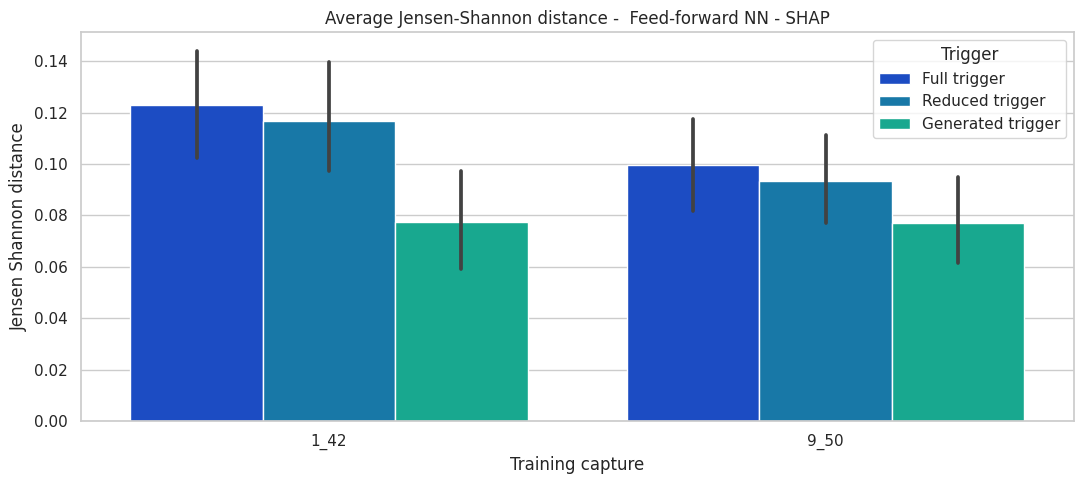

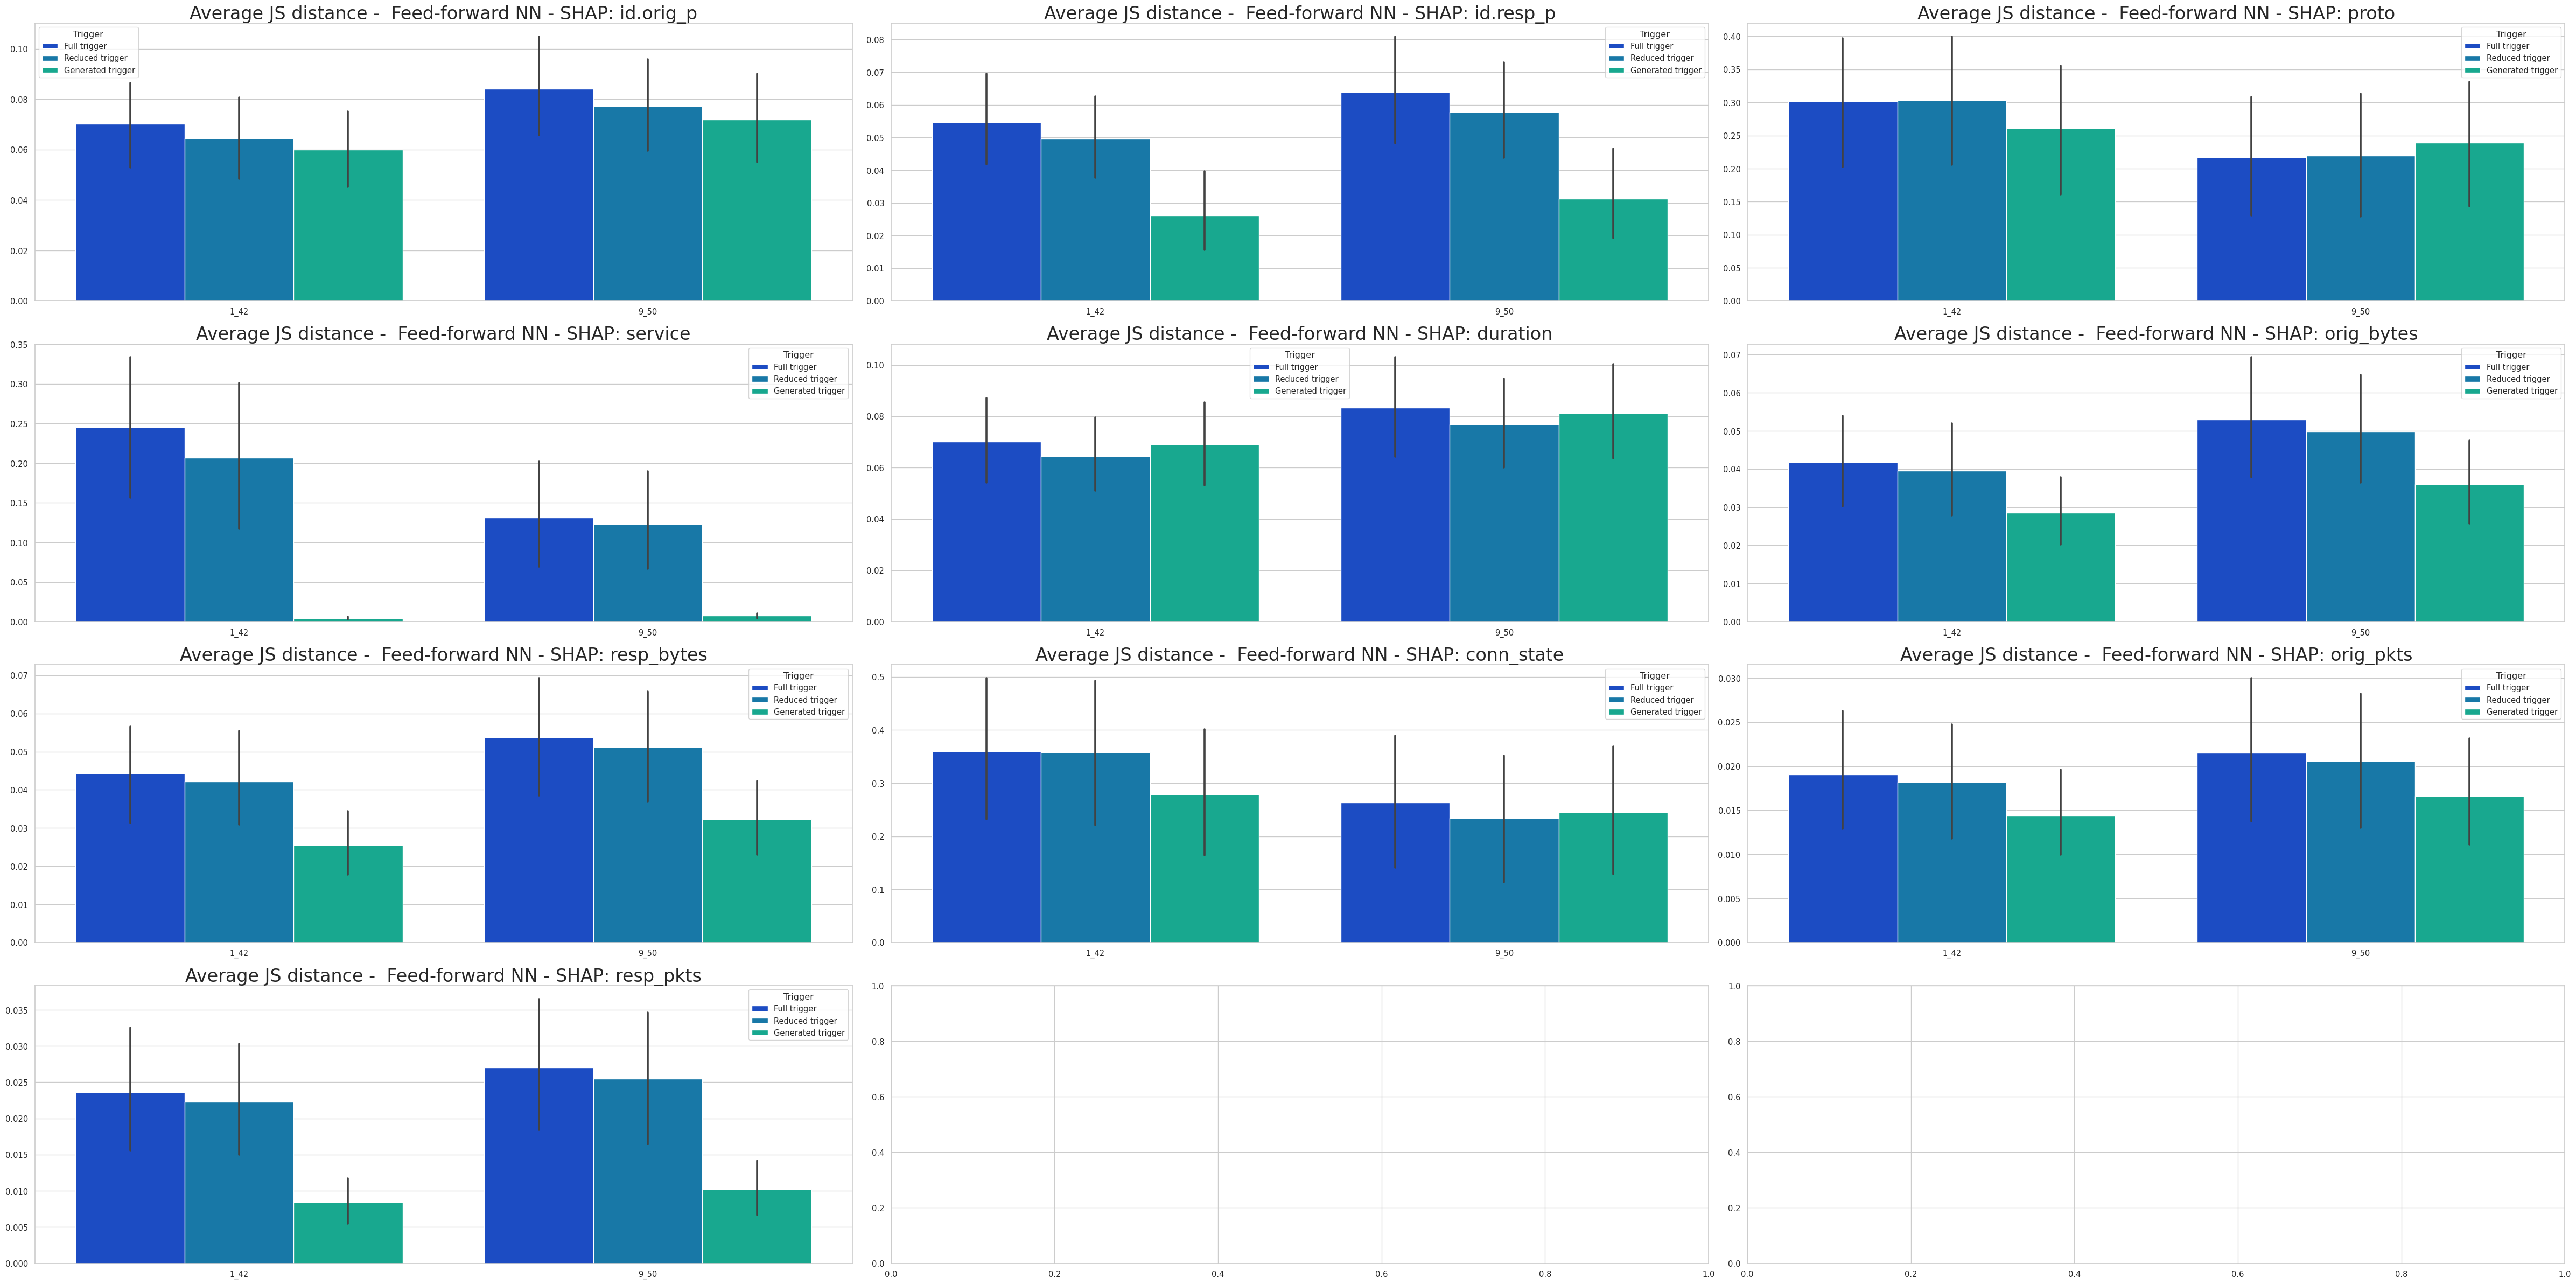

In [18]:
# Plot the average JS distance for each training capture -- single box plot
fig = plt.figure(figsize=(11, 5))
hue_order = ["full", "red", "gen"]
# sns.set(rc={"figure.dpi":300})
sns.set(rc={"figure.dpi":96})
sns.set_theme(style="whitegrid")

bp = sns.barplot(
    x="capture",
    y="distance",
    hue="trigger_type",
    data=distances_df,
    hue_order=hue_order,
    palette="winter"
)
bp.set_title(f"Average Jensen-Shannon distance -  {readable[model_type]} - {readable[fstrat]}")
bp.set_xlabel("Training capture")
bp.set_ylabel("Jensen Shannon distance")
leg = bp.get_legend()
leg.set_title(readable["trigger_type"])
texts_to_change = [readable[t.get_text()] for t in leg.texts]
for t, l in zip(leg.texts, texts_to_change):
    t.set_text(l)
plt.tight_layout()
plt.show()


# Create `num_to_show` subplots in a grid with 3 columns
grid_width = 3
grid_height = math.ceil(num_to_show / grid_width)
fig, axes = plt.subplots(nrows=grid_height, ncols=grid_width, figsize=(num_to_show * 5, 25))

for i, feat in enumerate(to_show_feats):
    ax = axes[i // grid_width, i % grid_width]
    bp = sns.barplot(
        x="capture",
        y="distance",
        hue="trigger_type",
        data=distances_df[distances_df["feature"] == feat],
        hue_order=hue_order,
        palette="winter",
        ax=ax,
    )
    bp.set_title(f"Average JS distance -  {readable[model_type]} - {readable[fstrat]}: {feat}", fontsize=25)
    bp.set_xlabel("")
    bp.set_ylabel("")
    leg = bp.get_legend()
    leg.set_title(readable["trigger_type"])
    texts_to_change = [readable[t.get_text()] for t in leg.texts]
    for t, l in zip(leg.texts, texts_to_change):
        t.set_text(l)
plt.tight_layout()
plt.show()

In [20]:
distances_js.to_csv(f"js_dist_ffnn_{fstrat}_c0.csv", index=False)

### Visualization

#### Baseline

In [28]:
# Compute the JS distance between the training data and the test data to use as a baseline
# for the JS distance between the training data and the poisoned data

train_captures = constants.subscenarios[scenario_tag]["train"][scenario_ind]
test_captures = constants.subscenarios[scenario_tag]["test"][scenario_ind]
print(train_captures)
print(test_captures)

['1_42', '9_50']
['2_43']


In [29]:
orig_sizes_c0, orig_uniques_c0, orig_unique_counts_c0 = get_uniques_by_feature(base_conn_logs_c0, ["1_42", "2_43", "9_50"])
orig_sizes_c1, orig_uniques_c1, orig_unique_counts_c1 = get_uniques_by_feature(base_conn_logs_c1, ["1_42", "2_43", "9_50"])

In [30]:
baseline_dists = []

for trn_c in train_captures:
    train_capture = base_conn_logs_c0[trn_c]

    for tst_c in test_captures:
        test_capture = base_conn_logs_c0[tst_c]

        # For each feature compute the JS distance
        cur_all_dists = []
        feats = list(test_capture.columns)
        for feat in feats:
            distance = get_js_dist_per_feature(
                orig_unique_counts_c0[trn_c][feat],
                orig_unique_counts_c0[tst_c][feat],
                orig_sizes_c0[trn_c][feat],
                orig_sizes_c0[tst_c][feat],
            )
            baseline_dists.append(
                {
                    "feature": feat,
                    "distance": distance,
                    "capture": (trn_c, tst_c),
                    "subscenario": scenario_ind,
                    "fstrat": fstrat,
                    "seed": exp_args[trig_type][stat_dir]["seed"],
                    "p_frac": exp_args[trig_type][stat_dir]["p_frac"],
                    "trigger_type": trig_type,
                }
            )
            cur_all_dists.append(distance)

        js_avg = np.average(cur_all_dists)
        baseline_dists.append(
            {
                "feature": "js_avg",
                "distance": js_avg,
                "capture": (trn_c, tst_c),
                "subscenario": scenario_ind,
                "fstrat": fstrat,
                "seed": exp_args[trig_type][stat_dir]["seed"],
                "p_frac": exp_args[trig_type][stat_dir]["p_frac"],
                "trigger_type": trig_type,
            }
        )

In [31]:
baseline_dists_df = pd.DataFrame.from_dict(baseline_dists)

In [32]:
baseline_dists_df[baseline_dists_df["feature"] == "js_avg"]

,feature,distance,capture,subscenario,fstrat,seed,p_frac,trigger_type
10,js_avg,0.224021,"(1_42, 2_43)",1,shap,1,0.05,red
21,js_avg,0.256272,"(9_50, 2_43)",1,shap,1,0.05,red


In [33]:
baseline_dists_df[baseline_dists_df["feature"] == "js_avg"]["distance"].mean()

0.240146380735274

#### Side by side model comparison

In [22]:
distances_js_gb = pd.read_csv("saved_files/js_dist_gb_entropy_c0.csv")
distances_js_gb_shap = pd.read_csv("saved_files/js_dist_gb_shap_c0.csv")
distances_js_ffnn = pd.read_csv("saved_files/js_dist_ffnn_entropy_c0.csv")
distances_js_ffnn_shap = pd.read_csv("saved_files/js_dist_ffnn_shap_c0.csv")
print("Shapes:", distances_js_gb.shape, distances_js_gb_shap.shape, distances_js_ffnn.shape, distances_js_ffnn_shap.shape)

Shapes: (150, 8) (150, 8) (150, 8) (150, 8)


In [23]:
unique_cols = ['feature', 'subscenario', 'fstrat', 'seed', 'p_frac', 'trigger_type']
distances_js_grp_gb = distances_js_gb.groupby(unique_cols)['distance'].mean().reset_index()
distances_js_grp_gb_shap = distances_js_gb_shap.groupby(unique_cols)['distance'].mean().reset_index()
distances_js_grp_ffnn = distances_js_ffnn.groupby(unique_cols)['distance'].mean().reset_index()
distances_js_grp_ffnn_shap = distances_js_ffnn_shap.groupby(unique_cols)['distance'].mean().reset_index()
print("Shapes:", distances_js_grp_gb.shape, distances_js_grp_gb_shap.shape, distances_js_grp_ffnn.shape, distances_js_grp_ffnn_shap.shape)

Shapes: (75, 7) (75, 7) (75, 7) (75, 7)


In [24]:
distances_js_grp_gb["model"] = "Gradient Boosting"
distances_js_grp_gb_shap["model"] = "Gradient Boosting"
distances_js_grp_ffnn["model"] = "Feed-forward NN"
distances_js_grp_ffnn_shap["model"] = "Feed-forward NN"

all_dist_js = pd.concat([distances_js_grp_gb, distances_js_grp_gb_shap, distances_js_grp_ffnn, distances_js_grp_ffnn_shap])
print("Shape:", all_dist_js.shape)

Shape: (300, 8)


In [25]:
to_show_dist_js = all_dist_js.copy()
to_show_dist_js["fstrat"] = to_show_dist_js["fstrat"].map({"entropy": "Entropy", "shap": "SHAP"})
to_show_dist_js_entropy = to_show_dist_js[to_show_dist_js["fstrat"] == "Entropy"].copy()
to_show_dist_js_shap = to_show_dist_js[to_show_dist_js["fstrat"] == "SHAP"].copy()
to_show_dist_js_entropy["model"] = ["Any"] * len(to_show_dist_js_entropy)
to_show_dist_js = pd.concat([to_show_dist_js_entropy, to_show_dist_js_shap])


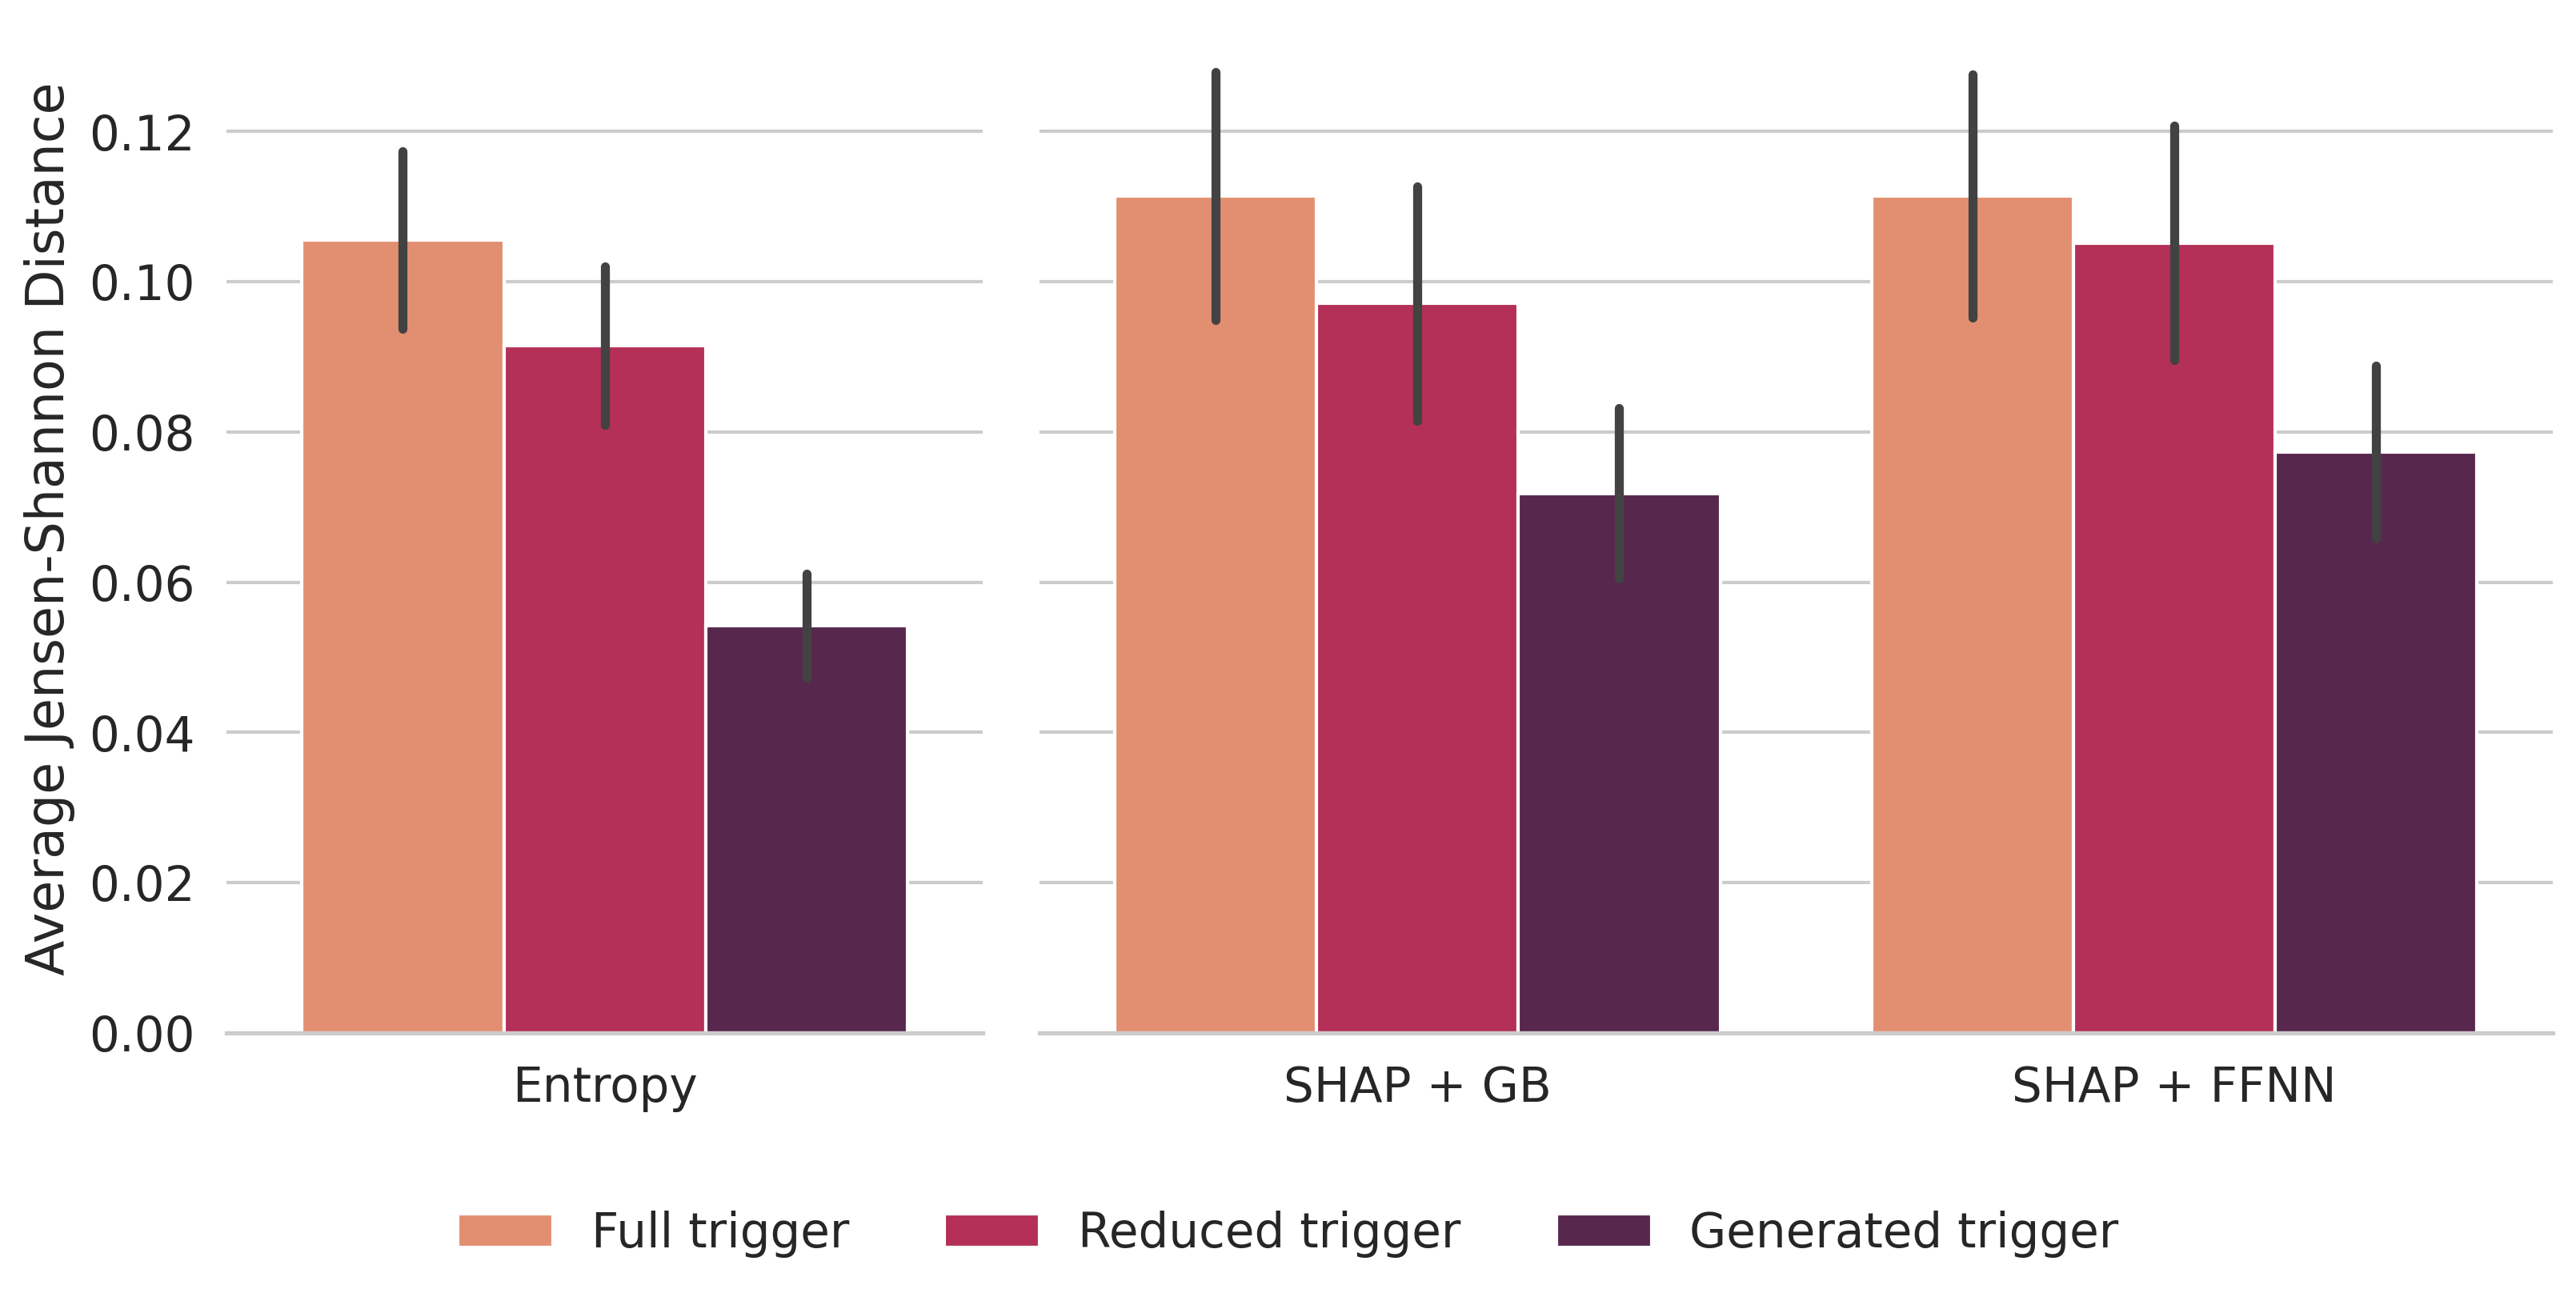

In [27]:
# Make two side by side barplot
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True, gridspec_kw={'width_ratios': [1, 2]})

# fig = plt.figure(figsize=(11, 5))
hue_order = ["full", "red", "gen"]
sns.set(font_scale=1.3, rc={"figure.dpi":300}, style="whitegrid")

bp_e = sns.barplot(
    x="model",
    y="distance",
    hue="trigger_type",
    data=to_show_dist_js[to_show_dist_js["fstrat"] == "Entropy"],
    hue_order=hue_order,
    palette="rocket_r",
    errorbar=("se"),
    ax=axes[0]
)
bp_s = sns.barplot(
    x="model",
    y="distance",
    hue="trigger_type",
    data=to_show_dist_js[to_show_dist_js["fstrat"] == "SHAP"],
    hue_order=hue_order,
    palette="rocket_r",
    errorbar=("se"),
    ax=axes[1]
)   

axes[1].set_ylabel('')
axes[0].set_ylabel('Average Jensen-Shannon Distance')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_xticklabels(["Entropy"])
axes[1].set_xticklabels(["SHAP + GB", "SHAP + FFNN"])

sns.despine(left=True, right=True)


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels = lines_labels[-1:]
for bp in [bp_e, bp_s]:
    bp.get_legend().remove()
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = [readable[l] for l in labels]
# labels = ["Entropy", "SHAP + GB", "SHAP + FFNN"]

# Set legend title    
leg = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, frameon=False)
# leg.set_title("Trigger Type")
leg.set_title(None)

plt.tight_layout()
plt.show()

In [ ]:
assert False

## Anomaly detection analysis

### Compute

In [ ]:
# Re-create training set
cl_1_42 = pd.read_csv(constants.ctu13_conn_log_pth.format("1_42"))
cl_2_43 = pd.read_csv(constants.ctu13_conn_log_pth.format("2_43"))
cl_9_50 = pd.read_csv(constants.ctu13_conn_log_pth.format("9_50"))
all_cl = {"1_42": cl_1_42, "2_43": cl_2_43, "9_50": cl_9_50}

train_captures = constants.subscenarios[scenario_tag]["train"][scenario_ind]
test_captures = constants.subscenarios[scenario_tag]["test"][scenario_ind]
train_conn_logs = {capture: all_cl[capture] for capture in train_captures}
test_conn_logs = {capture: all_cl[capture] for capture in test_captures}

# Extract aggregated features from the conn.log files
df_1_42, labels_1_42, rows_1_42 = data_utils.process_zeek_csv(
    all_cl["1_42"],
    internal_prefixes=data_utils.ds_internal_prefixes[scenario_tag],
    attacker_ips=data_utils.ds_attacker_ips[scenario_tag]["1_42"],
    t_window=30,
)
print("1_42 shape: {}".format(df_1_42.shape))
print("1_42 labels: {}".format(labels_1_42.shape))
print("1_42 labels: {}".format(np.unique(labels_1_42, return_counts=True)))
print("1_42 rows: {}".format(rows_1_42.shape))
df_2_43, labels_2_43, rows_2_43 = data_utils.process_zeek_csv(
    all_cl["2_43"],
    internal_prefixes=data_utils.ds_internal_prefixes[scenario_tag],
    attacker_ips=data_utils.ds_attacker_ips[scenario_tag]["2_43"],
    t_window=30,
)
print("2_43 shape: {}".format(df_2_43.shape))
print("2_43 labels: {}".format(labels_2_43.shape))
print("2_43 labels: {}".format(np.unique(labels_2_43, return_counts=True)))
print("2_43 rows: {}".format(rows_2_43.shape))
df_9_50, labels_9_50, rows_9_50 = data_utils.process_zeek_csv(
    all_cl["9_50"],
    internal_prefixes=data_utils.ds_internal_prefixes[scenario_tag],
    attacker_ips=data_utils.ds_attacker_ips[scenario_tag]["9_50"],
    t_window=30,
)
print("9_50 shape: {}".format(df_9_50.shape))
print("9_50 labels: {}".format(labels_9_50.shape))
print("9_50 labels: {}".format(np.unique(labels_9_50, return_counts=True)))
print("9_50 rows: {}".format(rows_9_50.shape))

assert np.array_equal(df_1_42.columns.to_numpy(), df_2_43.columns.to_numpy())
assert np.array_equal(df_1_42.columns.to_numpy(), df_9_50.columns.to_numpy())

all_df = {"1_42": df_1_42, "2_43": df_2_43, "9_50": df_9_50}
all_labels = {"1_42": labels_1_42, "2_43": labels_2_43, "9_50": labels_9_50}
all_rows = {"1_42": rows_1_42, "2_43": rows_2_43, "9_50": rows_9_50}

In [ ]:
orig_x_train = np.concatenate([all_df[tc].values for tc in train_captures])
orig_y_train = np.concatenate([all_labels[tc] for tc in train_captures])
orig_rows_train = np.concatenate([all_rows[tc] for tc in train_captures])
orig_src_train = np.concatenate(
    [np.full(all_df[tc].shape[0], tc) for tc in train_captures]
)

In [ ]:
def anomaly_worker(args):
    stat_dir, trig_type = args

    cur_seed = exp_args[trig_type][stat_dir]["seed"]
    tst_cp = test_captures[0]  # There is only one test capture
    tst_indices, adv_indices, = train_test_split(
        np.arange(all_df[tst_cp].values.shape[0]),
        test_size=0.15,
        random_state=cur_seed,
        stratify=all_labels[tst_cp],
    )
    tst_indices = np.sort(tst_indices)
    adv_indices = np.sort(adv_indices)
    # orig_x_test = all_df[tst_cp].values[tst_indices]
    # orig_y_test = all_labels[tst_cp][tst_indices]
    # orig_rows_test = all_rows[tst_cp][tst_indices]
    # orig_srct_test = np.full(orig_x_test.shape[0], tst_cp)
    # x_adv = all_df[tst_cp].values[adv_indices]
    # y_adv = all_labels[tst_cp][adv_indices]
    # adv_rows = all_rows[tst_cp][adv_indices]
    # adv_srct = np.full(x_adv.shape[0], tst_cp)

    cur_pois_idxs = exp_pois_idxs[trig_type][stat_dir].item()
    all_pois_idxs = [
        cur_pois_idxs[train_captures[0]],
        cur_pois_idxs[train_captures[1]] + all_df[train_captures[0]].shape[0],
    ]
    all_pois_idxs = np.concatenate(all_pois_idxs)

    target_x_train_idxs = np.where(orig_y_train == target_class)[0]
    # Select a subset of the training rows which are of the target class but not in all_pois_idxs
    target_x_train_idxs = np.setdiff1d(target_x_train_idxs, all_pois_idxs)
    defender_set_idxs, _ = train_test_split(
        target_x_train_idxs,
        train_size=int(0.1 * orig_x_train.shape[0]),
        random_state=cur_seed,
        shuffle=True,
    )
    defender_set_idxs = np.sort(defender_set_idxs)

    defender_set = orig_x_train[defender_set_idxs]
    # defender_set_labels = orig_y_train[defender_set_idxs]

    poisoned_x_train = [
        pd.read_csv(exp_df_pths[trig_type][stat_dir][tc]) for tc in train_captures
    ]
    poisoned_x_train = pd.concat(poisoned_x_train).values
    assert poisoned_x_train.shape == orig_x_train.shape

    isof = IsolationForest(
        n_estimators=100,
        max_samples="auto",
        contamination=0.01,
        random_state=cur_seed,
        n_jobs=1,
    )
    isof.fit(defender_set)
    anomaly_score_orig_x_train = isof.score_samples(orig_x_train)
    anomaly_score_poisoned_x_train = isof.score_samples(poisoned_x_train)
    anomaly_orig_x_train = isof.predict(orig_x_train)
    anomaly_poisoned_x_train = isof.predict(poisoned_x_train)
    isof_offset = isof.offset_

    actual_anomalies = np.zeros(orig_y_train.shape[0])
    actual_anomalies[all_pois_idxs] = 1

    return {
        "anomaly_score_orig_x_train": anomaly_score_orig_x_train,
        "anomaly_score_poisoned_x_train": anomaly_score_poisoned_x_train,
        "anomaly_orig_x_train": anomaly_orig_x_train,
        "anomaly_poisoned_x_train": anomaly_poisoned_x_train,
        "isof_offset": isof_offset,
        "actual_anomalies": actual_anomalies,
        "stat_dir": stat_dir,
        "trig_type": trig_type,
        "cur_seed": cur_seed,
    }


In [ ]:
# Use multiprocessing to speed up the computation
# Assign a subset of the combinations to each process
n_processes = 36
with Pool(n_processes) as p:
    isof_res = p.map(anomaly_worker, combinations)
print("Finished computing anomaly scores")
print("Len of isof_res: ", len(isof_res))

In [ ]:
np.save("isof_res_gb_shap.npy", isof_res)

### Visualization

Since these experiments are computationally expensive, we provide numpy files for each model and strategy.
The numpy files can be found at the link provided in the `README.md`.

In [10]:
# Change this to the desired model/strategy combination
isof_res = np.load(f"{base_path}/ctu13_neris/supervised/isolation_forest/isof_res_gb_shap.npy", allow_pickle=True)
print(isof_res.shape)

(75,)


In [11]:
to_show_df = pd.DataFrame.from_dict(isof_res.tolist())

In [23]:
p_fracs = []
for (stat_dir, trig_type) in combinations:
    p_fracs.append(exp_args[trig_type][stat_dir]["p_frac"])
to_show_df["p_frac"] = p_fracs

In [24]:
pois_fprs = []
pois_tprs = []
pois_roc_aucs = []
pois_roc_thrs = []
pois_precs = []
pois_recs = []
pois_pr_aucs = []
pois_pr_thrs = []

for i, row in to_show_df.iterrows():
    # Compute tpr and fpr for poisoned data
    pois_fpr, pois_tpr, roc_thr = roc_curve(
        row["actual_anomalies"], -row["anomaly_score_poisoned_x_train"]
    )
    pois_roc_auc = roc_auc_score(
        row["actual_anomalies"], -row["anomaly_score_poisoned_x_train"]
    )
    pois_prec, pois_rec, pc_thr = precision_recall_curve(
        row["actual_anomalies"], -row["anomaly_score_poisoned_x_train"]
    )
    pois_pr_auc = auc(pois_rec, pois_prec)
    pois_fprs.append(pois_fpr)
    pois_tprs.append(pois_tpr)
    pois_roc_aucs.append(pois_roc_auc)
    pois_roc_thrs.append(roc_thr)
    pois_precs.append(pois_prec)
    pois_recs.append(pois_rec)
    pois_pr_aucs.append(pois_pr_auc)
    pois_pr_thrs.append(pc_thr)

to_show_df["pois_fpr"] = pois_fprs
to_show_df["pois_tpr"] = pois_tprs
to_show_df["pois_roc_auc"] = pois_roc_aucs
to_show_df["pois_roc_thr"] = pois_roc_thrs
to_show_df["pois_prec"] = pois_precs
to_show_df["pois_rec"] = pois_recs
to_show_df["pois_pr_auc"] = pois_pr_aucs
to_show_df["pois_pr_thr"] = pois_pr_thrs

In [25]:
to_show_full = to_show_df[to_show_df["trig_type"] == "full"]
to_show_red = to_show_df[to_show_df["trig_type"] == "red"]
to_show_gen = to_show_df[to_show_df["trig_type"] == "gen"]
print("Shapes", to_show_full.shape, to_show_red.shape, to_show_gen.shape)

Shapes (25, 18) (25, 18) (25, 18)


In [26]:
all_to_show = {
    "full": to_show_full,
    "red": to_show_red,
    "gen": to_show_gen,
}
# Subset to only p_frac == 0.01
for trig_type in all_to_show.keys():
    all_to_show[trig_type] = all_to_show[trig_type][
        all_to_show[trig_type]["p_frac"] == 0.01
    ]

In [27]:
isof_accs = []
isof_f1s = []
isof_tn = []
isof_fp = []
isof_fn = []
isof_tp = []
for row in to_show_df.iterrows():
    anom_formatted = row[1]["anomaly_poisoned_x_train"]
    anom_formatted = np.array([1 if i == -1 else 0 for i in anom_formatted])
    acc = accuracy_score(row[1]["actual_anomalies"], anom_formatted)
    f1 = f1_score(row[1]["actual_anomalies"], anom_formatted)
    tn, fp, fn, tp = confusion_matrix(row[1]["actual_anomalies"], anom_formatted).ravel()
    isof_accs.append(acc)
    isof_f1s.append(f1)
    isof_tn.append(tn)
    isof_fp.append(fp)
    isof_fn.append(fn)
    isof_tp.append(tp)
    
to_show_df["Isolation Forest Accuracy"] = isof_accs
to_show_df["Isolation Forest F1"] = isof_f1s
to_show_df["Isolation Forest TN"] = isof_tn
to_show_df["Isolation Forest FP"] = isof_fp
to_show_df["Isolation Forest FN"] = isof_fn
to_show_df["Isolation Forest TP"] = isof_tp


In [28]:
def average_roc_curves(roc_curves_list,):
    """
    FROM: https://github.com/scikit-learn/scikit-learn/issues/23983
    This function takes the average of different length ROC curves returned from 
    sklearn.metrics.roc_curve. The function expects a list of fpr, tpr, and 
    thresholds. The function subsamples from these lists and returns an 
    average_fpr, average_tpr, and average_thresholds.

    Parameters
    ----------
    roc_curves_list : list
        A list of fpr, tpr, and thresholds
    Returns
    -------
    average_fpr : list
        A list of averaged false positive rates
    average_tpr : list
        A list of averaged true positive rates
    average_thresholds : list
        A list of averaged thresholds
    """
    kfolds = len(roc_curves_list)
    min_length = np.min(list(len(roc_curves_list[k][2]) for k in range(kfolds)))
    shortened_roc_curves_list = list()
    for k in range(kfolds):
        fpr, tpr, thresholds = roc_curves_list[k]
        indicies = list(i for i in range(len(thresholds)))
        selected_indicies = np.sort(np.random.choice(indicies, min_length, replace=False))
        shortened_roc_curves_list.append([fpr[selected_indicies], tpr[selected_indicies], thresholds[selected_indicies]])
    average_fpr, average_tpr, average_thresholds = np.mean(shortened_roc_curves_list, axis=0)
    return average_fpr, average_tpr, average_thresholds

In [29]:
all_to_show['full'].columns

Index(['anomaly_score_orig_x_train', 'anomaly_score_poisoned_x_train',
       'anomaly_orig_x_train', 'anomaly_poisoned_x_train', 'isof_offset',
       'actual_anomalies', 'stat_dir', 'trig_type', 'cur_seed', 'p_frac',
       'pois_fpr', 'pois_tpr', 'pois_roc_auc', 'pois_roc_thr', 'pois_prec',
       'pois_rec', 'pois_pr_auc', 'pois_pr_thr'],
      dtype='object')

In [30]:
to_show_df_01 = to_show_df[to_show_df["p_frac"]== 0.01]
table_df = to_show_df_01[["trig_type", "pois_pr_auc", "Isolation Forest F1"]].copy()
table_df = table_df.groupby("trig_type").mean()
display(table_df)

,pois_pr_auc,Isolation Forest F1
trig_type,,
full,0.098691,0.015137
gen,0.098612,0.018511
red,0.069829,0.012617
